# 1. Introduction

The advent of deep learning has ushered in a new era of medical diagnostics, offering unprecedented opportunities for automated analysis of complex medical imaging data. In the context of the analysis of chest X-ray images emerges as a critical area of study, particularly for the early detection of pulmonary abnormalities like pneumonia. Leveraging advancements in neural network architectures, this project explores curated chest X-ray dataset sourced from clinical settings.

## 1.1 Aim and Objective

The primary aim of this project is to develop and evaluate deep learning models for automated pneumonia diagnosis from chest X-ray images. The following objectives guide this endeavour:

- Develop robust neural network architectures tailored for chest X-ray image classification, with a focus on distinguishing between pneumonia and normal cases.


- Rigorously evaluate the performance of developed models using comprehensive metrics such as accuracy, ensuring robustness and reliability in pneumonia diagnosis.


- Assess the generalizability of developed models across diverse datasets and clinical settings, thereby enhancing their applicability and scalability in real-world scenarios.

## 1.3 Description of Dataset

The dataset utilized for this project is meticulously organized into three main folders—train, test, and validation — each containing subfolders for the two image categories: Pneumonia and Normal. It comprises a total of 5,863 high-resolution chest X-ray images in JPEG format, sourced from paediatric patients aged 1 to 5 years old at Guangzhou Women and Children’s Medical Centre, Guangzhou. Prior to inclusion, all images underwent stringent quality control measures, including screening for low-quality or unreadable scans, and subsequent grading by expert physicians. This dataset was obtained from the Kaggle repositiory "Chest X-Ray Images (Pneumonia)" by Paul Mooney, accessible via [1]

## 1.4 Defining the Problem

The problem at hand involves binary classification, where the goal is to classify chest X-ray images into two categories: Pneumonia and Normal. This problem falls under the domain of medical image analysis, with the objective of automating pneumonia diagnosis from chest X-ray images. 

In this project I will be developing and evaluating neural network architectures tailored for binary classification tasks, specifically for pneumonia diagnosis from chest X-ray images. I plan to explore 3 distinct architectures — Deep Model, Deeper Model, and Wider Model — each varying in depth, width, and regularization techniques. These architectures will be equipped with ReLU activation functions in the hidden layers and incorporate L2 regularization and dropout regularization to prevent overfitting. 

By systematically experimenting with these architectures and evaluating their performance using comprehensive metrics, I aim to identify the optimal model configuration that maximizes classification accuracy and generalization capabilities. 

# 2. Importing necessary libraries

In [1]:
import os
import pandas as pd
import matplotlib as mat
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

import random

from sklearn.model_selection import train_test_split, KFold
from sklearn import metrics
from sklearn.metrics import accuracy_score,balanced_accuracy_score
from sklearn.utils.class_weight import compute_class_weight

import keras
from keras.models import Sequential, clone_model
from keras.layers import Dense, Dropout, TextVectorization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras.utils import to_categorical
import tensorflow as tf
from keras.optimizers import RMSprop
from keras.metrics import F1Score, AUC

import glob
import cv2
import itertools

SEED = 204

tf.random.set_seed(SEED)
np.random.seed(SEED)

import warnings
warnings.filterwarnings('ignore')

# 3. Data pre-processing

In [2]:
main_path = "chest_xray"

train_path = os.path.join(main_path,"train")
test_path=os.path.join(main_path,"test")

train_normal = glob.glob(train_path+"/NORMAL/*.jpeg")
train_pneumonia = glob.glob(train_path+"/PNEUMONIA/*.jpeg")

test_normal = glob.glob(test_path+"/NORMAL/*.jpeg")
test_pneumonia = glob.glob(test_path+"/PNEUMONIA/*.jpeg")

num_train_normal = len(train_normal)
num_train_pneumonia = len(train_pneumonia)
num_test_normal = len(test_normal)
num_test_pneumonia = len(test_pneumonia)

print("Number of images in the training set:")
print("NORMAL:", num_train_normal)
print("PNEUMONIA:", num_train_pneumonia)
print("Total:", num_train_normal + num_train_pneumonia)

print("\nNumber of images in the test set:")
print("NORMAL:", num_test_normal)
print("PNEUMONIA:", num_test_pneumonia)
print("Total:", num_test_normal + num_test_pneumonia)

# Calculate total number of images in the training and test sets
total_train_images = num_train_normal + num_train_pneumonia
total_test_images = num_test_normal + num_test_pneumonia
total_images = total_train_images + total_test_images

# Calculate ratio of total number of training images to total number of test images
ratio_training = total_train_images / total_images
ratio_test = total_test_images / total_images

print(f"\nRatio of total number of training images to total number of test images: {ratio_training:.1f}: {ratio_test:.1f}")

Number of images in the training set:
NORMAL: 1349
PNEUMONIA: 3883
Total: 5232

Number of images in the test set:
NORMAL: 234
PNEUMONIA: 390
Total: 624

Ratio of total number of training images to total number of test images: 0.9: 0.1


There are only training and testing dataset from the dataset gotten from Kaggle, and the ratio of training to testing dataset is 0.9:0.1. I want to have my dataset split into 3 componenets: train, test and validation, with a ratio of 0.6:0.2:0.2, therefore, I will be shuffling all images from both folders and the split the data accordingly to the ratio 0.6:0.2:0.2 for train, test and validation respectively.

In [3]:
# Combine train and test datasets
all_normal = train_normal + test_normal
all_pneumonia = train_pneumonia + test_pneumonia

# Combine all images into a single list
all_images = all_normal + all_pneumonia

# Shuffle the combined list
random.shuffle(all_images)

# Calculate the sizes of each set
total_images = len(all_images)
train_size = int(0.6 * total_images)  # 60% for training
val_size = int(0.2 * total_images)    # 20% for validation
test_size = total_images - train_size - val_size  # Remaining 20% for testing

# Split the combined list into training, validation, and test sets
train_images = all_images[:train_size]
val_images = all_images[train_size:train_size+val_size]
test_images = all_images[train_size+val_size:]

# Separate images into NORMAL and PNEUMONIA classes
train_normal = [img for img in train_images if 'NORMAL' in img]
train_pneumonia = [img for img in train_images if 'PNEUMONIA' in img]

val_normal = [img for img in val_images if 'NORMAL' in img]
val_pneumonia = [img for img in val_images if 'PNEUMONIA' in img]

test_normal = [img for img in test_images if 'NORMAL' in img]
test_pneumonia = [img for img in test_images if 'PNEUMONIA' in img]

print("Number of images in the training set:")
print("NORMAL:", len(train_normal))
print("PNEUMONIA:", len(train_pneumonia))
print("Total:", len(train_images))

print("\nNumber of images in the validation set:")
print("NORMAL:", len(val_normal))
print("PNEUMONIA:", len(val_pneumonia))
print("Total:", len(val_images))

print("\nNumber of images in the test set:")
print("NORMAL:", len(test_normal))
print("PNEUMONIA:", len(test_pneumonia))
print("Total:", len(test_images))

Number of images in the training set:
NORMAL: 935
PNEUMONIA: 2578
Total: 3513

Number of images in the validation set:
NORMAL: 320
PNEUMONIA: 851
Total: 1171

Number of images in the test set:
NORMAL: 328
PNEUMONIA: 844
Total: 1172


## 3.1 Normalizing image

Normalization standardizes the pixel values of images, ensuring consistency and facilitating convergence during model training. The normalization process involves scaling the pixel values to a range between 0 and 1. This is achieved by dividing each pixel value by the maximum pixel value (255 for images) to ensure that all pixel values fall within the desired range. By normalizing the images, it ensures that the model's training process is more stable and efficient, as it reduces the impact of variations in pixel intensity across different images. 

In [4]:
# Function to load and preprocess images
def preprocess_images(image_paths, image_size):
    images = []
    for path in image_paths:
        image = cv2.imread(path)
        image = cv2.resize(image, (image_size, image_size))  # Resize image
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #gray scale
        image = image.astype(np.float32) / 255.0  # Normalize pixel values
        images.append(image)
    return np.array(images)

In [5]:
# Function to prepare labels
def prepare_labels(labels):
    # Assuming binary classification (0 for NORMAL, 1 for PNEUMONIA)
    return np.array(labels)

In [6]:
# Load images and labels
all_normal = train_normal + test_normal
all_pneumonia = train_pneumonia + test_pneumonia
all_images = all_normal + all_pneumonia
all_labels = [0] * len(all_normal) + [1] * len(all_pneumonia)

# Preprocess images
image_size = 64
X = preprocess_images(all_images, image_size)

# Prepare labels
y = prepare_labels(all_labels)

In [7]:
np.unique(y)

array([0, 1])

# 4. Train, Test and Split

In [8]:
# Split the data into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)  # 0.25 * 0.8 = 0.2

In [9]:
# Print the shapes of the data
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of y_val:", y_val.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (2998, 64, 64)
Shape of y_train: (2998,)
Shape of X_val: (750, 64, 64)
Shape of y_val: (750,)
Shape of X_test: (937, 64, 64)
Shape of y_test: (937,)


## 4.1 Reshaping image

The Chest X-Ray images are represented as 3-dimensional arrays, but the algorithm implementation below requires 2-dimensional input. Reshaping converts the images into 2-dimensional arrays, where each row represents a single image flattened into a 1-dimensional array. This simplifies the input representation, facilitating model training and improving performance in classification tasks.

In [11]:
# Reshape X_train, X_val, and X_test to 2-dimensional arrays
X_train = X_train.reshape(X_train.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# Cast as floats and rescale from 0 to 1
X_train = X_train.astype('float32') / 255
X_val = X_val.astype('float32') / 255
X_test = X_test.astype('float32') / 255

# Print the shapes after reshaping
print("Shape of X_train after reshaping:", X_train.shape)
print("Shape of X_val after reshaping:", X_val.shape)
print("Shape of X_test after reshaping:", X_test.shape)

Shape of X_train after reshaping: (2998, 4096)
Shape of X_val after reshaping: (750, 4096)
Shape of X_test after reshaping: (937, 4096)


In [10]:
# Cast as floats
y_train = y_train.astype('float32')
y_val = y_val.astype('float32')
y_test = y_test.astype('float32')

In [12]:
X_train.shape, y_train.shape

((2998, 4096), (2998,))

# 5. Naive Baseline

Establishing a naive baseline is important as it provides a simple benchmark for comparing the performance of more complex models. By setting a minimum level of accuracy based on basic predictions, such as always choosing the most frequent class, we gain perspective on the relative effectiveness of advanced algorithms. This baseline aids in understanding the task's difficulty and guides the selection and optimization of models.

In [13]:
# Calculate the frequency of each class in the training set
unique_classes, class_counts = np.unique(y_train, return_counts=True)

# Find the most frequent class
most_frequent_class = unique_classes[np.argmax(class_counts)]

# Calculate the baseline accuracy assuming all predictions are the most frequent class
baseline_accuracy = np.max(class_counts) / len(y_train)

print("Most frequent class in the training set:", most_frequent_class)
print("Naive Baseline accuracy:", baseline_accuracy*100)

Most frequent class in the training set: 1.0
Naive Baseline accuracy: 73.21547698465643


In [14]:
labels = np.argmax(y_train, axis=0)
weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
CLASS_WEIGHT = dict(enumerate(weights))

CLASS_WEIGHT

{0: 1.8667496886674968, 1: 0.6829157175398634}

Class 0: This class has a weight of approximately 1.87. This means that during training, samples belonging to class 0 will be given approximately 1.87 times more importance than samples belonging to other classes. It indicates that class 0 is less frequent in the dataset, so it needs more weight to balance its representation during training.

Class 1: This class has a weight of approximately 0.68. This means that during training, samples belonging to class 1 will be given approximately 0.68 times the importance of samples belonging to other classes. It indicates that class 1 is more frequent in the dataset, so it needs less weight to balance its representation during training.

# 6. Developing a model that does better than a baseline

## 6.1 Plotting of graph function

In [15]:
def plot_loss(loss,val_loss):
  #plot training loss and validation loss on the graph
  plt.clf() #discard any existing features
  epochs=range(1,len(loss)+1)#get a number of epochs

  #assign values for each axis
  plt.plot(epochs,loss,'bo',label="Loss")
  plt.plot(epochs,val_loss,label="Validation Loss", color= "red")

  #set a title of graph and labels of each axis
  plt.title("Training Loss & Validation Loss")
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

In [16]:
def plot_accuracy(acc,val_acc):
  #plot training accuracy and validation accuracy
  plt.clf()#discard any existing features
  epochs=range(1,len(acc)+1) #get a number of epochs

  #assign labels and values for each axis
  plt.plot(epochs,acc,'ro',label="Accuracy")
  plt.plot(epochs,val_acc,label="Validation Accuracy" , color ="purple")

  #set a title of graph and labels of each axis
  plt.title("Training and validation accuracy")
  plt.xlabel('Epochs')
  plt.ylabel("Accuracy")
  plt.legend()
  plt.show()

## 6.2 Baseline architecture

In [17]:
INPUT_DIMENSION = X_train.shape[1]
OUTPUT_DIMENSION = 1

OPTIMIZER = 'rmsprop'
LOSS_FUNC = 'binary_crossentropy'
METRICS = ['accuracy',
           F1Score(name='f1_score', average="weighted"),
           AUC(num_thresholds=2, name='auc')]

MONITOR = 'val_loss'
PATIENCE = 5

EARLY_STOP = EarlyStopping(monitor=MONITOR, restore_best_weights=True, patience=PATIENCE, verbose=0)

The selection of RMSprop as the optimization algorithm and Binary Crossentropy as the loss function is pivotal for training neural networks in binary classification tasks. 

RMSprop, renowned for its adaptability to varying gradients, enhances convergence speed and stability by adjusting learning rates based on recent gradient magnitudes. This mitigates issues related to noisy gradients and erratic oscillations, ensuring smoother and more reliable training. [2]

Meanwhile, Binary Crossentropy serves as an apt choice for binary classification, efficiently quantifying the disparity between true labels and predicted probabilities. Specifically tailored for binary scenarios, it penalizes inaccurate predictions more severely, facilitating effective model training, particularly when utilizing sigmoid activation functions in the output layer. [3]

Together, the combination of RMSprop and Binary Crossentropy optimizes the training process, fostering the development of robust neural network models for binary classification tasks. 

The evaluation metrics used to evaluate the model would be by accuracy as functions provided by Tensorflow are unable to properly evaluate metrics such as F1 score and AUC since the test and validation dataset is very small.

In [18]:
baseline = Sequential(
    [
        Dense(OUTPUT_DIMENSION, activation='sigmoid', input_shape=(INPUT_DIMENSION,))
    ],
    name="baseline"
)

baseline.summary()

Model: "baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 4097      
                                                                 
Total params: 4097 (16.00 KB)
Trainable params: 4097 (16.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


The baseline model is built with sigmoid activation function because it exists between 0 and 1. The sigmoid activation function is especially used for models to predict the probability as an output, since probability only exists between the range of 0 and 1.

In [19]:
learning_rate = 0.05
batch_size = 64
EPOCHS = 100

In [20]:
baseline.compile(optimizer=RMSprop(learning_rate=learning_rate),
                 loss=LOSS_FUNC, metrics=METRICS)

In [21]:
baseline_history = baseline.fit(X_train, y_train,
                                class_weight=CLASS_WEIGHT,
                                batch_size=batch_size, epochs=EPOCHS,
                                validation_data=(X_val, y_val),
                                callbacks=[EARLY_STOP],
                                verbose=0)

In [22]:
baseline_scores = baseline.evaluate(X_val, y_val, verbose=0)[1:]

print('Accuracy (Validation): {:.2f} (Naive Baseline = {:.2f})'.format(baseline_scores[0], baseline_accuracy))

Accuracy (Validation): 0.93 (Naive Baseline = 0.73)


The accuracy of a trained model on a validation dataset is assessed, yielding a score of 0.92. A naive baseline accuracy of 0.73 is provided for comparison, representing the accuracy achieved by predicting the most frequent class for all instances.This comparison determines if the model's accuracy outperforms the naive baseline approach. With an accuracy of 0.92, the model demonstrates its effectiveness in surpassing the simple baseline and making accurate predictions on the validation set.

In [23]:
preds = baseline.predict(X_val, verbose=0)

print('Balanced Accuracy (Validation): {:.2f} (Naive Baseline = {:.2f})'.format(balanced_accuracy_score(y_val, (preds >= 0.5)), baseline_accuracy))

Balanced Accuracy (Validation): 0.91 (Naive Baseline = 0.73)


The balanced accuracy score is compared to the naive baseline accuracy its effectiveness in surpassing the naive baseline with 0.90 > 0.73.

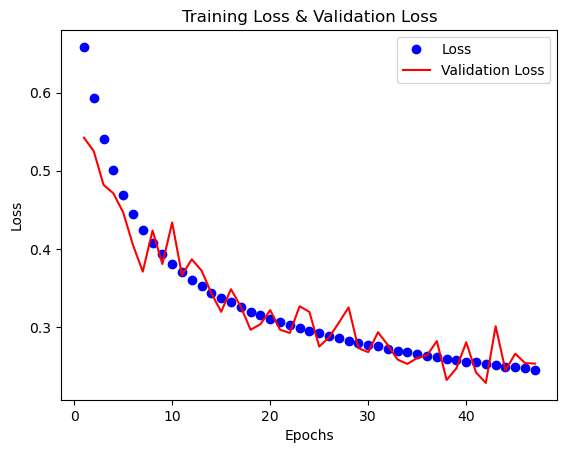

In [24]:
plot_loss(loss=baseline_history.history['loss'], val_loss=baseline_history.history['val_loss'])

The training loss (blue dots) shows a general decline with some fluctuations, suggesting the model is still learning and improving its performance over time. The validation loss (red line) also shows a decline but with more pronounced fluctuations. This could be due to the model’s performance varying more on the unseen validation data. However, the gap between the training loss and validation loss seems to be increasing as the number of epochs increases. This could be a sign of overfitting, where the model is becoming too specialized to the training data and performs less well on unseen data.

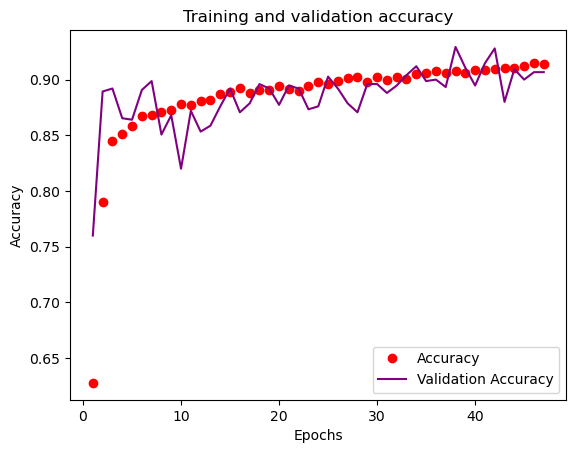

In [25]:
plot_accuracy(acc=baseline_history.history['accuracy'],val_acc=baseline_history.history['val_accuracy'])

The training accuracy (red dots) shows an increase over time, indicating that the model is correctly learning from the training data. The validation accuracy (purple line) also shows an increase but with some fluctuations. This could be due to the model’s performance varying more on the unseen validation data.

# 7. Scaling up: developing a model that overfits

To scale up to develop a model that overfits, number of layers have been increased from (1 layer to 3 layers), dimension of layer are also increased from (1 to 32, 64 and 128), as well as increasing the epochs from (100 to 300).

In [26]:
learning_rate = 0.01
EPOCHS = 300
batch_size = 64

In [27]:
overfit = Sequential([
    Dense(128, activation="relu", input_shape=(INPUT_DIMENSION,), name="hidden1"),
    Dense(64, activation="relu", name="hidden2"),
    Dense(32, activation="relu", name="hidden3"),
    Dense(OUTPUT_DIMENSION, activation="sigmoid", name="output")
], name="overfit")

In [28]:
overfit.compile(optimizer=RMSprop(learning_rate=learning_rate),
                loss=LOSS_FUNC, metrics=METRICS)

overfit_history = overfit.fit(X_train, y_train,
                              class_weight=CLASS_WEIGHT,
                              batch_size=batch_size, epochs=EPOCHS,
                              validation_data=(X_val, y_val),
                              callbacks=[],
                              verbose=0)

In [29]:
overfit_scores = overfit.evaluate(X_val, y_val, verbose=0)[1:]

print('Accuracy (Validation): {:.2f} (Naive Baseline = {:.2f})'.format(overfit_scores[0], baseline_accuracy))

Accuracy (Validation): 0.91 (Naive Baseline = 0.73)


Validation accuracy is clearly shown to be larger than naive basline accuracy, this demonstrates the effectiveness of the model which overfits.

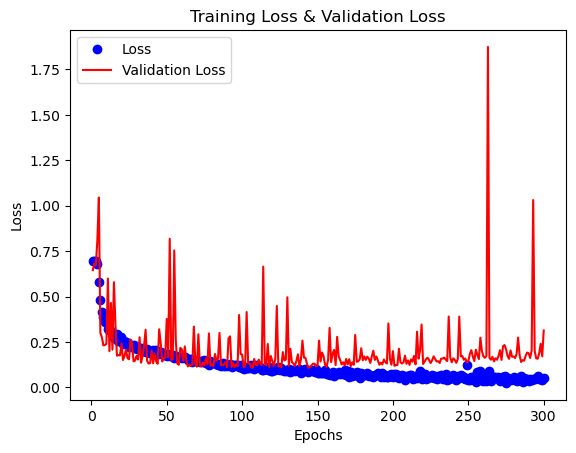

In [30]:
plot_loss(loss=overfit_history.history['loss'], val_loss=overfit_history.history['val_loss'])

The training loss (blue dots) shows a consistent decrease over time, indicating improvement in model performance on training data. The validation loss (red line) fluctuates with noticeable spikes, suggesting variability in model performance on unseen or validation data. The training loss is significantly lower than the validation loss from epochs value 125 onwards, it is a sign of overfitting.

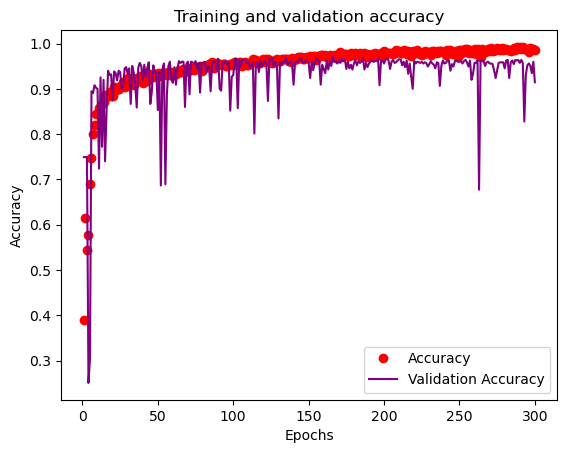

In [31]:
plot_accuracy(acc=overfit_history.history['accuracy'],val_acc=overfit_history.history['val_accuracy'])

The training accuracy (red dots) shows a rapid increase and then plateaus near 1.0, indicating that the model is fitting the training data well. The validation accuracy (purple line) also increases but then plateaus at a lower value than the training accuracy, suggesting that the model is overfitting to the training data.

# 8. Regularizing and tuning hyperparameters

## 8.1 Deep Model

This deep model is built on top of the overfit model, with dropout layers and kernel regularizer included. 

Dropout is a regularization technique used to prevent overfitting. Dropout layer will randomly drop out outputs of the previous layer according to the dropout rate. [4]

Kernel regularizer is also another technique to prevent overfitting by discouraging the network from using large weights in the model. Regularization is the process of adding penalty factors to the network layers to alter the weight propagation with the help of the layers that are facilitating the model to optimise the covergence. [5]

In [32]:
# over-sized model - neural network architecture that can overfit the data
def DeepModel(l2_penalty, dropout_rate) :
    return Sequential(
        [
            Dense(128, kernel_regularizer=l2(l2_penalty), activation="relu", input_shape=(INPUT_DIMENSION,), name="hidden1"),
            Dropout(rate=dropout_rate),
            Dense(64, kernel_regularizer=l2(l2_penalty), activation="relu", name="hidden2"),
            Dropout(rate=dropout_rate),
            Dense(32, kernel_regularizer=l2(l2_penalty), activation="relu", name="hidden3"),
            Dropout(rate=dropout_rate),
            Dense(OUTPUT_DIMENSION,  activation='sigmoid', name='output')
        ],
        name="deep"
    )

## 8.2 Deeper Model

The deeper model has one more dense and dropout layer added to it with a dense layer dimension of 32.

In [33]:
def DeeperModel(l2_penalty, dropout_rate) :
   return Sequential(
      [
          Dense(128, kernel_regularizer=l2(0.001), activation="relu", input_shape=(INPUT_DIMENSION,), name="hidden1"),
          Dropout(rate=dropout_rate),
          Dense(64, kernel_regularizer=l2(0.001), activation="relu", name="hidden2"),
          Dropout(rate=dropout_rate),
          Dense(32, kernel_regularizer=l2(0.001), activation="relu", name="hidden3"),
          Dropout(rate=dropout_rate),
          Dense(32, kernel_regularizer=l2(0.001), activation="relu", name="hidden4"),
          Dropout(rate=dropout_rate),
          Dense(OUTPUT_DIMENSION,  activation='sigmoid', name='output')
      ],
      name = 'deeper'
   )



## 8.3 Wider Model

The wider model has the same number of layers as deep model, however, the dense layers has more dimension, up till 256. 

In [34]:
def WiderModel(l2_penalty, dropout_rate) :
   return Sequential(
       [
          Dense(256, kernel_regularizer=l2(l2_penalty), activation="relu", input_shape=(INPUT_DIMENSION,), name="hidden1"),
          Dropout(rate=dropout_rate),
          Dense(128, kernel_regularizer=l2(l2_penalty), activation="relu", name="hidden2"),
          Dropout(rate=dropout_rate),
          Dense(64, kernel_regularizer=l2(l2_penalty), activation="relu", name="hidden3"),
          Dropout(rate=dropout_rate),
          Dense(OUTPUT_DIMENSION,  activation='sigmoid', name='output')
      ],
      name = 'wider'
   )

# 9. k-Fold Cross Validation

K-fold cross-validation is a powerful technique used to assess machine learning model performance by partitioning the dataset into k subsets, with each fold serving as a validation set while the others are used for training. 

In the context of this project involving binary classification of medical images, k-fold cross-validation ensures robust evaluation across multiple data subsets, reducing the risk of overfitting and providing a more reliable estimate of model generalization. By averaging performance metrics across folds, it offers insight into the model's consistency and effectiveness, crucial for real-world deployment. 

Additionally, cross-validation facilitates hyperparameter tuning by systematically exploring different configurations, enhancing model optimization. Overall, k-fold cross-validation enhances the reliability, robustness, and generalization of model evaluation in the binary classification of medical images.

In [35]:
# reduced grid size for testing correctness of the cross-validation function
parameters = {
    'dropout': [0.0, 0.1, 0.2, 0.3],
    'alpha': [0.0, 0.001, 0.01, 0.1],
    'learning_rate': [0.01],
    'batch_size': [32]
}

EPOCHS = 200

In [36]:
def cross_validation(X, y, cv, model, class_weight, param_grid, loss, metrics, epochs, callbacks, seed=0) :
    kf = KFold(n_splits=cv)
    keys, values = zip(*param_grid.items())

    # cross-validation scores
    cvs = {}
    for params in [dict(zip(keys, v)) for v in itertools.product(*values)] :
        scores = []
        for i, (train_index, test_index) in enumerate(kf.split(X)) :
            nn = model(l2_penalty=params['alpha'], dropout_rate=params['dropout']) #clone_model(model)

            nn.compile(optimizer=RMSprop(learning_rate=params['learning_rate']),
                       loss=loss, metrics=metrics)

            nn.fit(X[train_index,:], y[train_index],
                   class_weight=class_weight,
                   batch_size=params['batch_size'], epochs=epochs,
                   validation_data=(X[test_index,:], y[test_index]),
                   callbacks=callbacks,
                   verbose=0)

            scores.append(nn.evaluate(X[test_index,:], y[test_index], verbose=0))

        cvs[str(params)] = np.array(scores).mean(axis=0)

    return cvs

In [37]:
def dict_to_dataframe(cvs, metrics) :
    entries = []
    for key, value in cvs.items() :
        entry = eval(key)

        for metric, score in zip(metrics, value) :
            entry[metric] = score

        entries.append(entry)

    return pd.DataFrame(entries)

## 9.1 Results

As mentioned above, the data points are relatively small, therefore the  functions provided by Tensorflow are unable to properly evaluate metrics such as F1 score and AUC. The metrics to evaluate the most optimal model and it's architecture would be one of the highest accuracy. The cross validation will run through a series of different hyperparameters and the architecuture of each model will be sorted by the highest accuracy at the top and lowest at the bottom.

### 9.1.1 Deep Model

In [38]:
cvs_deep = cross_validation(X_train, y_train, cv=3, model=DeepModel,
                            class_weight=CLASS_WEIGHT,
                            param_grid=parameters, loss=LOSS_FUNC, metrics=METRICS,
                            epochs=EPOCHS,
                            callbacks=[EARLY_STOP], seed=SEED)

In [39]:
cvs_deep = dict_to_dataframe(cvs=cvs_deep, metrics=['loss', 'accuracy', 'f1_score', 'auc'])
cvs_deep.sort_values(by=['accuracy'], ascending=False)

,dropout,alpha,learning_rate,batch_size,loss,accuracy,f1_score,auc
8,0.2,0.000,0.01,32,0.188043,0.925946,0.845338,0.5
4,0.1,0.000,0.01,32,0.211308,0.924942,0.845338,0.5
12,0.3,0.000,0.01,32,0.217542,0.914938,0.845338,0.5
0,0.0,0.000,0.01,32,0.505575,0.798558,0.845338,0.5
1,0.0,0.001,0.01,32,0.683744,0.732158,0.845338,0.5
2,0.0,0.010,0.01,32,0.681585,0.732158,0.845338,0.5
3,0.0,0.100,0.01,32,1.884776,0.732158,0.845338,0.5
5,0.1,0.001,0.01,32,0.681478,0.732158,0.845338,0.5
6,0.1,0.010,0.01,32,0.681519,0.732158,0.845338,0.5
7,0.1,0.100,0.01,32,1.882443,0.732158,0.845338,0.5


### 9.2 Deeper Model

In [40]:
cvs_deeper = cross_validation(X_train, y_train, cv=3, model=DeeperModel,
                            class_weight=CLASS_WEIGHT,
                            param_grid=parameters, loss=LOSS_FUNC, metrics=METRICS,
                            epochs=EPOCHS,
                            callbacks=[EARLY_STOP], seed=SEED)

In [41]:
cvs_deeper = dict_to_dataframe(cvs=cvs_deeper, metrics=['loss', 'accuracy', 'f1_score', 'auc'])
cvs_deeper.sort_values(by=['accuracy'], ascending=False)

,dropout,alpha,learning_rate,batch_size,loss,accuracy,f1_score,auc
0,0.0,0.000,0.01,32,0.680001,0.732158,0.845338,0.5
1,0.0,0.001,0.01,32,0.684352,0.732158,0.845338,0.5
2,0.0,0.010,0.01,32,0.682986,0.732158,0.845338,0.5
3,0.0,0.100,0.01,32,0.679188,0.732158,0.845338,0.5
4,0.1,0.000,0.01,32,0.682207,0.732158,0.845338,0.5
5,0.1,0.001,0.01,32,0.682655,0.732158,0.845338,0.5
6,0.1,0.010,0.01,32,0.680271,0.732158,0.845338,0.5
7,0.1,0.100,0.01,32,0.676651,0.732158,0.845338,0.5
8,0.2,0.000,0.01,32,0.677513,0.732158,0.845338,0.5
9,0.2,0.001,0.01,32,0.680393,0.732158,0.845338,0.5


### 9.2 Wider Model

In [42]:
cvs_wider = cross_validation(X_train, y_train, cv=3, model=WiderModel,
                             class_weight=CLASS_WEIGHT,
                             param_grid=parameters, loss=LOSS_FUNC, metrics=METRICS,
                             epochs=EPOCHS,
                             callbacks=[EARLY_STOP], seed=SEED)

In [43]:
cvs_wider = dict_to_dataframe(cvs=cvs_wider, metrics=['loss', 'accuracy', 'f1_score', 'auc'])
cvs_wider.sort_values(by=['accuracy'], ascending=False)

,dropout,alpha,learning_rate,batch_size,loss,accuracy,f1_score,auc
8,0.2,0.000,0.01,32,0.179354,0.931951,0.845338,0.5
12,0.3,0.000,0.01,32,0.204955,0.919275,0.845338,0.5
4,0.1,0.000,0.01,32,0.345962,0.869222,0.845338,0.5
0,0.0,0.000,0.01,32,0.506032,0.795222,0.845338,0.5
1,0.0,0.001,0.01,32,0.679930,0.732158,0.845338,0.5
2,0.0,0.010,0.01,32,0.679240,0.732158,0.845338,0.5
3,0.0,0.100,0.01,32,3.131101,0.732158,0.845338,0.5
5,0.1,0.001,0.01,32,0.679005,0.732158,0.845338,0.5
6,0.1,0.010,0.01,32,0.680878,0.732158,0.845338,0.5
7,0.1,0.100,0.01,32,3.125841,0.732158,0.845338,0.5


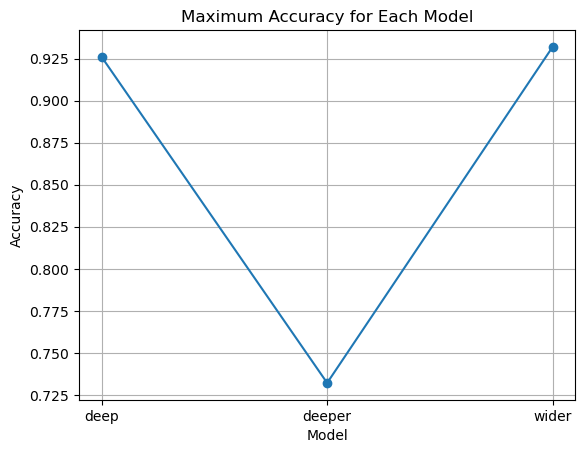

In [64]:
#plotting of accuracy to compare between models.
models = ['deep','deeper', 'wider']
accuracies = [cvs_deep['accuracy'].max(), cvs_deeper['accuracy'].max(), cvs_wider['accuracy'].max()]

# Plot as a line graph
plt.plot(models, accuracies, marker='o', linestyle='-')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Maximum Accuracy for Each Model')
plt.grid(True)
plt.show()

Based on the accuracy scores, the **wider model** is the most optimal model to be used on the Chest X-Ray binary classification dataset, with accuracy of 0.93 and parameters: 

- dropout: 0.02
- alpha: 0.000
- learning rate: 0.01
- batch size: 32

# 10. Testing

In [50]:
# optimal parameters are taken out from our k-fold grid-search stats
# deep
best_params = {
    'dropout': 0.2,
    'alpha': 0.000,
    'learning_rate': 0.01,
    'batch_size': 32
}

best_model = WiderModel(l2_penalty=best_params['alpha'], dropout_rate=best_params['dropout'])

best_model.compile(optimizer=RMSprop(learning_rate=best_params['learning_rate']),
                   loss=LOSS_FUNC, metrics=METRICS)

history = best_model.fit(X_train, y_train,
                         class_weight=CLASS_WEIGHT,
                         batch_size=best_params['batch_size'], epochs=EPOCHS,
                         validation_data=(X_val, y_val),
                         callbacks=[EARLY_STOP],
                         verbose=0)

In [51]:
validation_scores = best_model.evaluate(X_val, y_val, verbose=0)[1:]

print('Accuracy (Validation): {:.2f} (Naive Baseline = {:.2f})'.format(validation_scores[0], baseline_accuracy))

Accuracy (Validation): 0.94 (Naive Baseline = 0.73)


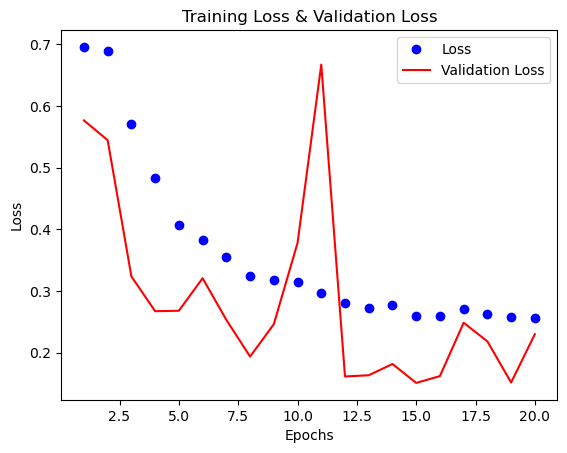

In [52]:
plot_loss(loss=history.history['loss'], val_loss=history.history['val_loss'])

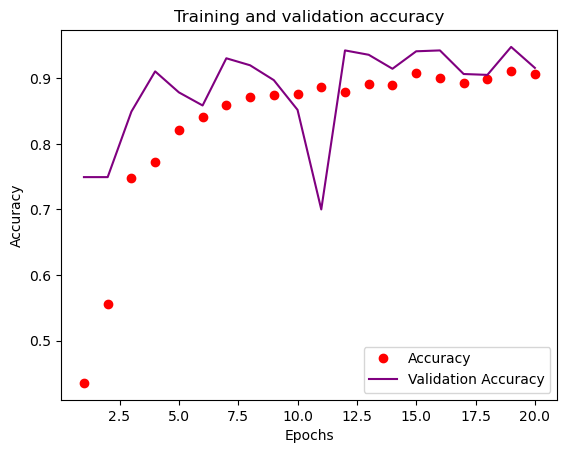

In [53]:
plot_accuracy(acc=history.history['accuracy'],val_acc=history.history['val_accuracy'])

In [54]:
test_scores = best_model.evaluate(X_test, y_test, verbose=0)[1:]

print('Accuracy (Test): {:.2f} (Naive Baseline = {:.2f})'.format(test_scores[0], baseline_accuracy))

Accuracy (Test): 0.92 (Naive Baseline = 0.73)


Based on the above graphs and test accuracy, it is shown the the model that has been retrained is of a similar accuracy result as the cross validation evaluation, where test accuracy is 0.92 and cross validation is 0.93. This shows that the wider model is well re-trained and has the most optimal architecture to ensure that the chest x-ray images are detected correctly and categorized under the correct class. 

With reference to both graphs, there seems to be a sharp dip in the validation accuracy and validation loss, this could be due to both validation and training sets are finite and incomplete samples of the sample space. Hence the validation metrics may be more noisy since validation set has a much smaller datapoint than the training dataset. Overall, the validation accuracy and validation loss follows the downward trend of the training accuracy and training loss generally. This show that the model is optimal.

# 11. Conclusion

In conclusion, the primary aim of this project was to develop and evaluate deep learning models for automated pneumonia diagnosis from chest X-ray images. Through rigorous experimentation and evaluation, it has been determined that the wider learning model, with the specified architecture and parameters, stands out as the most optimal choice for binary classification of chest X-ray images. With a dropout rate of 0.02, L2 regularization coefficient of 0.000, learning rate of 0.01, and batch size of 32, this model demonstrates superior performance in accurately distinguishing between pneumonia and normal cases. Its robustness, reliability, and high accuracy scores make it well-suited for integration into clinical workflows, potentially enhancing diagnostic efficiency and supporting healthcare professionals in decision-making processes.

In light of the retraining of the model, the final accuracy test score of 0.92 signifies a notable improvement over the naive baseline accuracy of 0.73. This underscores the effectiveness of the developed deep learning model in accurately classifying chest X-ray images for pneumonia diagnosis. With a substantial increase in accuracy, the model demonstrates its capability to reliably differentiate between pneumonia and normal cases, thereby enhancing diagnostic efficiency and potentially aiding healthcare professionals in decision-making processes.

# 12. References.

[1]: Mooney Paul. 2018. Chest X-Ray Images (Pneumonia). Available at:  https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

[2]: Aditya Taparia. 2023. Gradient Descent With RMSProp from Scratch. Available at:  https://www.geeksforgeeks.org/gradient-descent-with-rmsprop-from-scratch/

[3]: Shipra Saxena. 2023. Binary Cross Entropy/Log Loss for Binary Classification. Available at:  https://www.analyticsvidhya.com/blog/2021/03/binary-cross-entropy-log-loss-for-binary-classification/#:~:text=Binary%20Cross%20Entropy%2C%20also%20known,binary%20labels%20of%20a%20dataset.

[4]: Aston Zhang, Zack C. Lipton, Mu Li, Alex J. Smola. No Date. 5.6. Dropout. Available at:  https://d2l.ai/chapter_multilayer-perceptrons/dropout.html

[5]: Francis Benistant. 2023. Part5: Neural Network Regression with Keras and TensorFlow: Custom Regularization function and Custom Activity Regularization function to Avoid Overfitting in Neural Networks. Available at:  https://2020machinelearning.medium.com/part5-neural-network-regression-with-keras-and-tensorflow-custom-regularization-function-and-74b081f87273#:~:text=On%20the%20other%20hand%2C%20kernel,the%20weights%20in%20the%20network.